In [1]:
! git pull
%pylab inline
import seaborn as sns
from scipy.stats import zscore
from pandas import read_csv
from tqdm import tnrange, tqdm_notebook
from time import sleep
import CCD_packages
reload(CCD_packages)

Already up-to-date.
Populating the interactive namespace from numpy and matplotlib


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



<module 'CCD_packages' from 'CCD_packages.pyc'>

In [2]:
import nilearn.datasets
from nilearn import input_data

print('Datasets shipped with nilearn are stored in: %r' % nilearn.datasets.get_data_dirs())
atlas=nilearn.datasets.fetch_atlas_msdl()

Datasets shipped with nilearn are stored in: ['/home/jmuraskin/nilearn_data']


In [3]:
GroupDF,motionInfo=CCD_packages.getCCDSubjectData()
goodsubj,badsubj = CCD_packages.getSubjectList(GroupDF=GroupDF,motionThresh=1)

masker = nilearn.input_data.NiftiMapsMasker(
    atlas.maps, resampling_target="maps", detrend=False,
    t_r=2.0, standardize=True,
    memory='nilearn_cache', memory_level=1)


# subjects = []
# sites = []
fb = []
subjGroup=[]
for subjNum,subj in enumerate(goodsubj): 
    print 'Running Subject %s' % subj
    for run in [1,2]:
        func_file='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/functional_mni_other_resolutions_smooth/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz' % (subj,run)
#         time_series = masker.fit_transform(func_file)
#         subjects.append(time_series)
        subjGroup.append(subjNum)
        fb.append(CCD_packages.subjectinfo_scan(subj,run))


No DR .txt file found or error for subject : CCD061
No DR .txt file found or error for subject : CCD061
Running Subject CCD012
Running Subject CCD014
Running Subject CCD015
Running Subject CCD016
Running Subject CCD017
Running Subject CCD018
Running Subject CCD019
Running Subject CCD020
Running Subject CCD021
Running Subject CCD022
Running Subject CCD023
Running Subject CCD024
Running Subject CCD025
Running Subject CCD026
Running Subject CCD027
Running Subject CCD031
Running Subject CCD032
Running Subject CCD034
Running Subject CCD040
Running Subject CCD041
Running Subject CCD042
Running Subject CCD052
Running Subject CCD053
Running Subject CCD059
Running Subject CCD060
Running Subject CCD063
Running Subject CCD064
Running Subject CCD065
Running Subject CCD067
Running Subject CCD071
Running Subject CCD073
Running Subject CCD074
Running Subject CCD075
Running Subject CCD080
Running Subject CCD081
Running Subject CCD082
Running Subject CCD084
Running Subject CCD085
Running Subject CCD088

In [5]:
import pickle

load_or_save = 0
if load_or_save:
    favorite_color = { 'subjectTimeSeries': subjects,'fb':fb}
    pickle.dump( favorite_color, open( "MSDL_global0_FB_NFB.p", "wb" ) )
else:
    favorite_color = pickle.load( open( "MSDL_global0_FB_NFB.p", "rb" ) )
    subjects=favorite_color['subjectTimeSeries']
    fb=favorite_color['fb']

In [6]:
import nilearn.connectome
kinds = ['tangent', 'partial correlation', 'correlation','precision']
individual_connectivity_matrices = {}
mean_connectivity_matrix = {}
for kind in kinds:
    conn_measure = nilearn.connectome.ConnectivityMeasure(kind=kind)
    individual_connectivity_matrices[kind] = conn_measure.fit_transform(
        subjects)
    # Compute the mean connectivity
    if kind == 'tangent':
        mean_connectivity_matrix[kind] = conn_measure.mean_
    else:
        mean_connectivity_matrix[kind] = \
            individual_connectivity_matrices[kind].mean(axis=0)

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



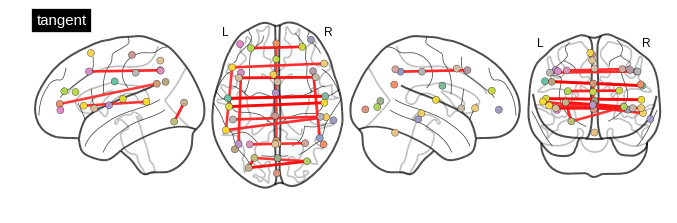

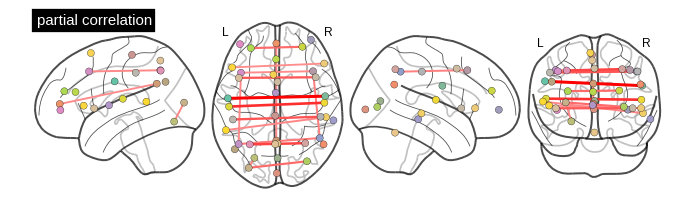

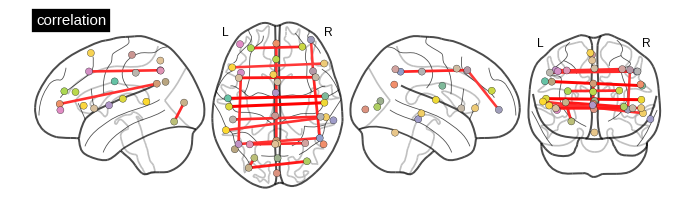

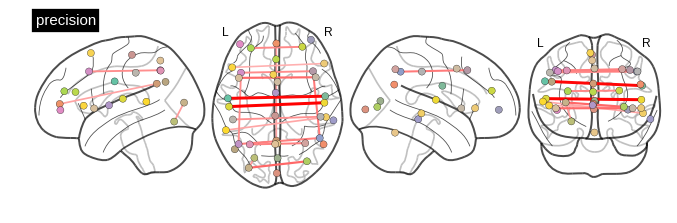

In [7]:
import nilearn.plotting
labels = atlas.labels
region_coords = atlas.region_coords
for kind in kinds:
    nilearn.plotting.plot_connectome(-mean_connectivity_matrix[kind] if kind=='precision' else mean_connectivity_matrix[kind],
                                     region_coords, edge_threshold='98%',
                                     title=kind, display_mode='lzry')

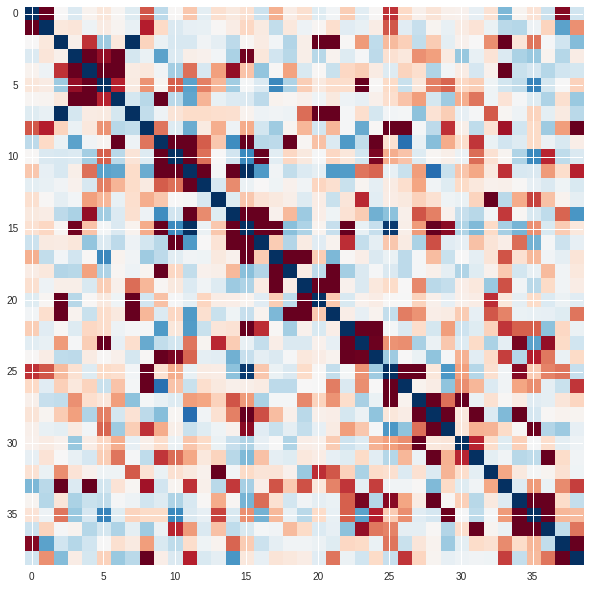

In [8]:
plt.figure(figsize=(10, 10))
# Mask the main diagonal for visualization:
CCD_packages.np.fill_diagonal(-mean_connectivity_matrix['precision'],0)

plt.imshow(-mean_connectivity_matrix['precision'], interpolation="nearest", cmap="RdBu_r",
           vmax=0.8, vmin=-0.8)

In [9]:
indices=CCD_packages.np.triu_indices(39,1)

In [33]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score,LeaveOneGroupOut
from sklearn.metrics import roc_auc_score
import random
 
y = CCD_packages.np.zeros((len(fb),))
for indx,fbtmp in enumerate(fb):
    if fbtmp=='Feedback':
        y[indx]=1

print('Classification accuracy:')
mean_scores = []


    

def groupScaling(X,group):
    from sklearn.preprocessing import scale, StandardScaler
    X_new = X.copy()
    for groupVal in unique(group):
        #get indices
        indx=group==groupVal
        X_new[indx,:]=scale(X[indx,:],with_mean=True, with_std=False)
    ss=StandardScaler()
    ss.fit_transform(X_new)    
    return X_new

def leaveOneGroupOutCV(clf,X,y,group):
    from sklearn.model_selection import LeaveOneGroupOut
    lol = LeaveOneGroupOut()
    y_pred=zeros((len(y),))
    coefs_= []
    for train_index, test_index in lol.split(X, y, group):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train,y_train)
        y_pred[test_index]=clf.decision_function(X_test)
        coefs_.append(clf.coef_)
    coefs_= np.mean(coefs_,axis=0)
    return y_pred,coefs_

def shuffleOrders(y,group):
    y_new = y.copy()
    for groupVal in unique(group):
        indx=group==groupVal
        y_tmp=y_new[indx]
        random.shuffle(y_tmp)
        y_new[indx]=y_tmp
    return y_new
    
coefs={}
y_preds={}

kinds = ['tangent']


nperms=1000
scale=1
for kind in kinds:
    svc = SGDClassifier(loss='hinge', penalty='l1', alpha=.001,l1_ratio=1)
    # Transform the connectivity matrices to 1D arrays
    coonectivity_coefs = nilearn.connectome.sym_to_vec(
        individual_connectivity_matrices[kind],discard_diagonal=True)
    if scale:
        X_new=groupScaling(coonectivity_coefs,subjGroup)
    else:
        X_new=coonectivity_coefs.copy()   
#     y_pred,coefs_=leaveOneGroupOutCV(svc,coonectivity_coefs,y,subjGroup)
    if nperms>0:
        permAUC=[]
        for n in tnrange(nperms, desc='Permutations'):
            y_new=shuffleOrders(y,subjGroup)
            y_pred,coefs_=leaveOneGroupOutCV(svc,X_new,y_new,subjGroup)
            permAUC.append(roc_auc_score(y_new,y_pred))
            sleep(0.01)
    
    y_pred,coefs_=leaveOneGroupOutCV(svc,X_new,y,subjGroup)
    
    print('%20s score: %1.2f' % (kind, roc_auc_score(y,y_pred)))
    mean_scores.append(roc_auc_score(y,y_pred))
    coefs[kind]=coefs_
    y_preds[kind]=y_pred

Classification accuracy:

             tangent score: 1.00


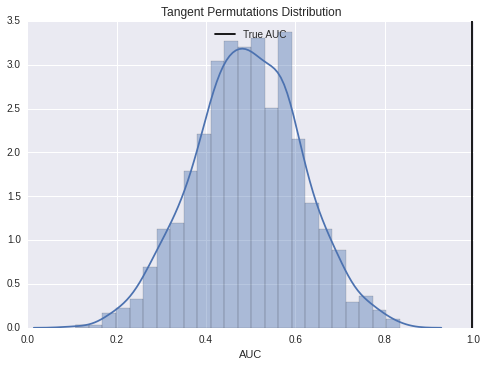

In [34]:
ax=sns.distplot(permAUC)
ax.set_title('Tangent Permutations Distribution')
ax.set_xlabel('AUC')
plt.vlines(mean_scores,ax.get_ylim()[0],ax.get_ylim()[1],label='True AUC')
ax.legend(loc='upper center')

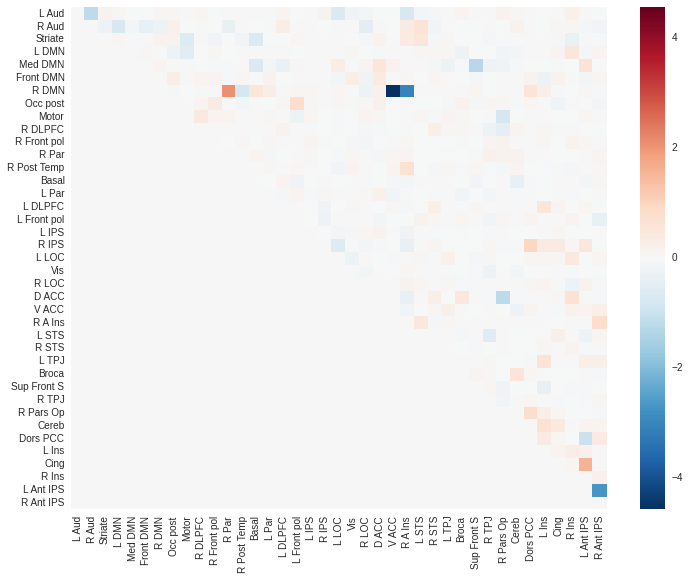

In [35]:
# edgelist=CCD_packages.np.zeros((1,741))
# for p in params:
#     p[abs(p)>10e-6]=1.0
#     edgelist+=p
kind='tangent'
edge_map=CCD_packages.np.zeros((39,39))
edge_map[indices]=coefs[kind]
# edge_map[indices[1,:],indices[0,:]]=edgelist/47
plt.subplots(figsize=(12,9))
sns.heatmap(edge_map,xticklabels=labels,yticklabels=labels)

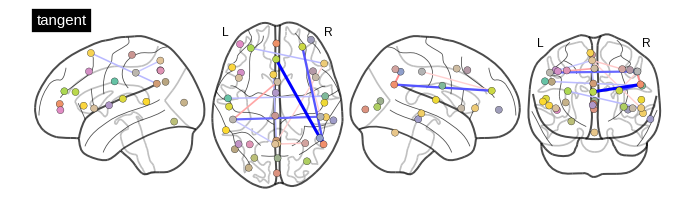

In [36]:
nilearn.plotting.plot_connectome((edge_map + edge_map.T)/2,
                                 region_coords, edge_threshold='98.5%',
                                 title=kind, display_mode='lzry')

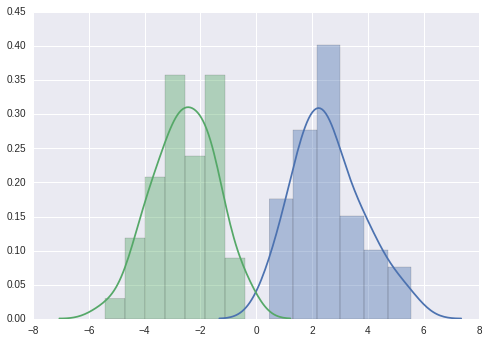

In [32]:
import seaborn as sns


sns.distplot(y_preds[kind][y==1])
sns.distplot(y_preds[kind][y==0])



/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



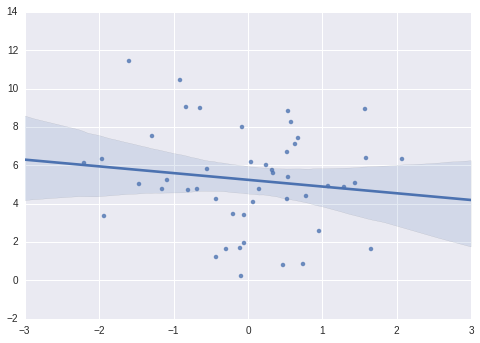

In [37]:
from pandas import read_csv
performance=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_performance.csv',names=['Subject_ID','FB','scanorder','R'])
fbNames=['FEEDBACK','NOFEEDBACK']
fb=1

y_perf=zscore(np.array(CCD_packages.np.arctanh(performance[performance.FB==fbNames[0]][performance.Subject_ID.isin(goodsubj)]['R']).values)-np.array(CCD_packages.np.arctanh(performance[performance.FB==fbNames[1]][performance.Subject_ID.isin(goodsubj)]['R']).values))

sns.regplot(y_perf,y_preds['tangent'][y==1]-y_preds['tangent'][y==0])

In [ ]:
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
y_tmp

In [ ]:
! pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org tqdm